numerical_results/lorenz_3d_cv_result_diffusion_512_skip-connection.pkl
mode = diffusion, map_type = skip-connection, N = 512, maxvpt = 13.425229999999999
numerical_results/lorenz_3d_cv_result_diffusion_1024_skip-connection.pkl
mode = diffusion, map_type = skip-connection, N = 1024, maxvpt = 15.073239999999998
numerical_results/lorenz_3d_cv_result_diffusion_2048_skip-connection.pkl
mode = diffusion, map_type = skip-connection, N = 2048, maxvpt = 16.48738
numerical_results/lorenz_3d_cv_result_diffusion_4096_skip-connection.pkl
mode = diffusion, map_type = skip-connection, N = 4096, maxvpt = 16.49102
numerical_results/lorenz_3d_cv_result_rbf_512_skip-connection.pkl
mode = rbf, map_type = skip-connection, N = 512, maxvpt = 10.62789
numerical_results/lorenz_3d_cv_result_rbf_1024_skip-connection.pkl
mode = rbf, map_type = skip-connection, N = 1024, maxvpt = 13.18954
numerical_results/lorenz_3d_cv_result_rbf_2048_skip-connection.pkl
mode = rbf, map_type = skip-connection, N = 2048, maxvpt = 

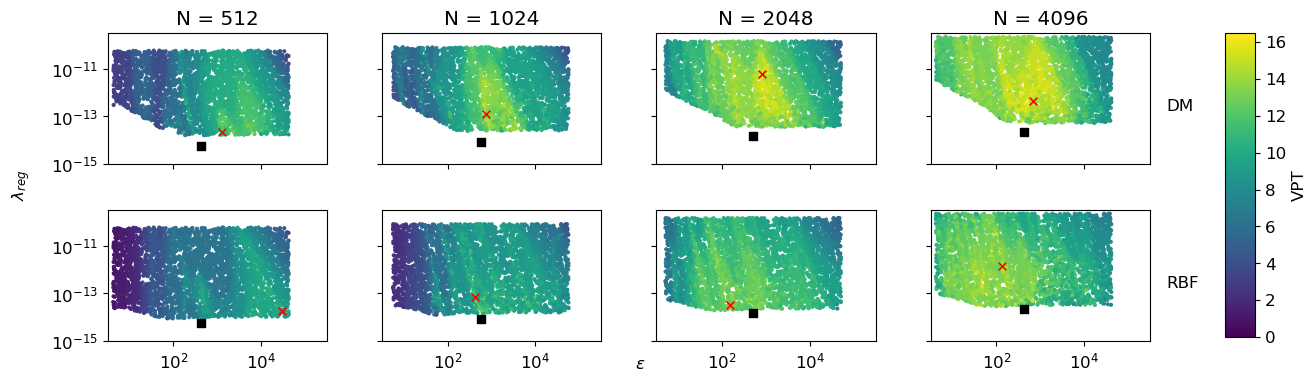

In [18]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl

RESULTS_DIR = "numerical_results"
TITLE = "lorenz_3d"

N_LIST = [512, 1024, 2048, 4096]

ROW_ORDER = [
    # ("diffusion", "direct"),
    ("diffusion", "skip-connection"),
    # ("rbf",       "direct"),
    ("rbf",       "skip-connection"),
]
MODE_LABEL = {"diffusion": "DM", "rbf": "RBF"}

cmap = "viridis"
point_size = 4
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

def cv_path(mode: str, N: int, map_type: str) -> str:
    return os.path.join(RESULTS_DIR, f"lorenz_3d_cv_result_{mode}_{N}_{map_type}.pkl")

cv_data = {}
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

for mode, map_type in ROW_ORDER:
    for N in N_LIST:
        fp = cv_path(mode, N, map_type)
        print(fp)
        if not os.path.exists(fp):
            print("File does not exist")
            continue
        try:
            with open(fp, "rb") as f:
                df = pickle.load(f)
        except Exception as e:
            print(f"[WARN] failed to read {fp}: {e}")
            continue
        _idx = 0
        eps = df["epsilon"][_idx]
        lam = df["lambda"][_idx]
        vpt = df["vpt"][_idx]
        print(f"mode = {mode}, map_type = {map_type}, N = {N}, maxvpt = {np.max(vpt)}")

        lamm = df["lambda_min"][_idx]
        epsc = df["epsilon_c"][_idx]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )

        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, N)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))

if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid VPT values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)


def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(ROW_ORDER), len(N_LIST)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13   # gap between right edge of subplots and colorbar
CBAR_W  = 0.028  # colorbar width
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)


sc_last = None

for r, (mode, map_type) in enumerate(ROW_ORDER):
    for c, N in enumerate(N_LIST):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"N = {N}")

        if c == cols - 1:
            ax.set_ylabel(f"{MODE_LABEL[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, N)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        eps_c = D["epsc"]
        lam_m = D["lamm"]

        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]

        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, lam_m, c="black", marker='s', s=30)
        sc_last = sc

        idx = np.nanargmax(vpt_v)
        best_eps = eps_v[idx]
        best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(0.5), 10**(5.5)])
        ax.set_ylim(10**(-15), 10**(-9.5))

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(2):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(4):
    ax = axs[1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)


# fig.savefig("./journal_pics/lorenz_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)


numerical_results/lorenz_3d_cv_result_diffusion_1024_skip-connection_trial.pkl
mode = diffusion, map_type = skip-connection, N = 1024, maxvpt = 13.65


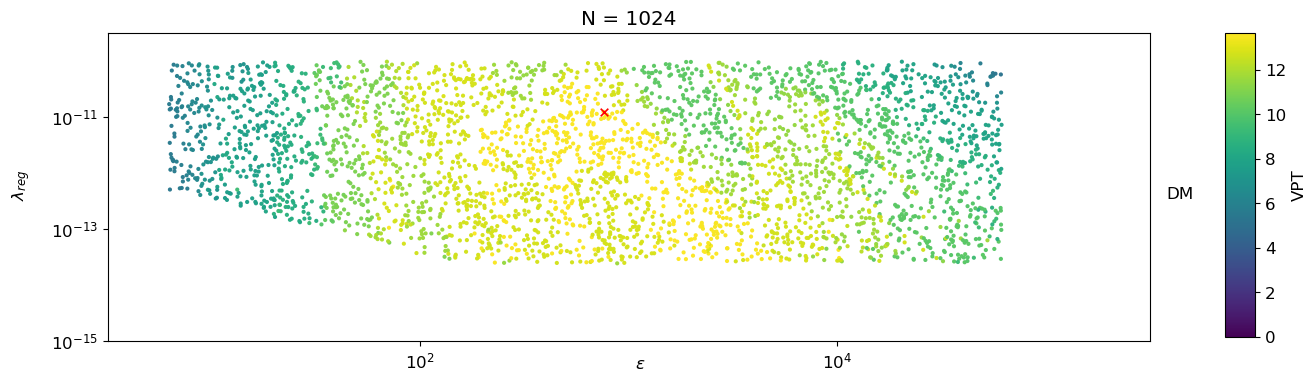

In [4]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl

RESULTS_DIR = "numerical_results"
TITLE = "lorenz_3d"

N_LIST = [1024] #[512, 1024, 2048, 4096]

ROW_ORDER = [
    # ("diffusion", "direct"),
    ("diffusion", "skip-connection"),
    # ("rbf",       "direct"),
    # ("rbf",       "skip-connection"),
]
MODE_LABEL = {"diffusion": "DM", "rbf": "RBF"}

cmap = "viridis"
point_size = 4
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

def cv_path(mode: str, N: int, map_type: str) -> str:
    return os.path.join(RESULTS_DIR, f"lorenz_3d_cv_result_{mode}_{N}_{map_type}_trial.pkl")

cv_data = {}
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

for mode, map_type in ROW_ORDER:
    for N in N_LIST:
        fp = cv_path(mode, N, map_type)
        print(fp)
        if not os.path.exists(fp):
            print("File does not exist")
            continue
        try:
            with open(fp, "rb") as f:
                df = pickle.load(f)
        except Exception as e:
            print(f"[WARN] failed to read {fp}: {e}")
            continue
        _idx = 2
        eps = df["epsilon"][_idx]
        lam = df["lambda"][_idx]
        vpt = df["vpt"][_idx]
        print(f"mode = {mode}, map_type = {map_type}, N = {N}, maxvpt = {np.max(vpt)}")

        lamm = df["lambda_min"][_idx]
        epsc = df["epsilon_c"][_idx]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )

        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, N)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))

if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid VPT values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)


def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(ROW_ORDER), len(N_LIST)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13   # gap between right edge of subplots and colorbar
CBAR_W  = 0.028  # colorbar width
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)


sc_last = None

for r, (mode, map_type) in enumerate(ROW_ORDER):
    for c, N in enumerate(N_LIST):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"N = {N}")

        if c == cols - 1:
            ax.set_ylabel(f"{MODE_LABEL[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, N)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        eps_c = D["epsc"]
        lam_m = D["lamm"]

        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]

        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, lam_m, c="black", marker='s', s=30)
        sc_last = sc

        idx = np.nanargmax(vpt_v)
        best_eps = eps_v[idx]
        best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(0.5), 10**(5.5)])
        ax.set_ylim(10**(-15), 10**(-9.5))

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

# for r in range(2):
#     ax = axs[r, 0]
#     ax.tick_params(axis="y", which="both", left=True, labelleft=True)
#     ax.yaxis.set_major_locator(y_locator)
ax.tick_params(axis="y", which="both", left=True, labelleft=True)
ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)

# for c in range(4):
#     ax = axs[1, c]
#     ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
#     ax.xaxis.set_major_locator(x_locator)


# fig.savefig("./journal_pics/lorenz_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)


In [37]:
mode = "diffusion"
num_points = 512
map_type = "skip-connection"
validation_horizon_lst = [1500] #[500 + 200*i for i in range(8)]

for i, validation_horizon in enumerate(validation_horizon_lst):
    path = f"numerical_results/lorenz_3d_cv_result_{mode}_{num_points}_{map_type}_vl_{2*validation_horizon}.pkl"
    with open(path, "rb") as f:
        cv_results = pickle.load(f)
    vpts = cv_results["vpt"]
    count_lst = []
    for _ in range(500):
        max_vpts = np.max(vpts[_]) 
        count = np.sum(vpts[_] == max_vpts)
        count_lst.append(count)

In [38]:
count_lst[:10]

[1, 1, 79, 1, 2, 1, 1, 4, 1, 16]

In [43]:
vpts.shape

(500, 4096)

In [26]:
import cupy as cp
import general_utils


devices = 4
dt = 0.01
cv_trials_per_device = 1024
mode_list = ["diffusion", "rbf"]
map_type_lst = ['skip-connection']
test_trials = 500
error_threshold = 0.3 ** 2
Lyapunov_exp = 0.91

title = f"lorenz_3d"

# Datasets 
train = np.load("./cached_data/lorenz_train.npy").T
validation_horizon = 1500
validation_size_multiplier = 4/3
validation_repeats = 3

validation_length = int(validation_horizon * validation_size_multiplier)
print(f"validation_length = {validation_length}")

map_type = "skip-connection"

opts = {
"map_type": map_type,
"norm": False,
}
    
num_points = 1024


n_chunk_lst = []


print(f"chunk size = {n_chunk_lst}")

np.random.seed(142)
data_indices = np.random.randint(
    train.shape[0] - (num_points + validation_size_multiplier*validation_horizon), size=test_trials
)

print(f"  num_points={num_points}, map_type={map_type}")


train = np.load("./cached_data/lorenz_train.npy").T
test = np.load('./cached_data/lorenz_test.npy').transpose(0, 2, 1)
n_test, T, d = test.shape

# Load CV results
path = f"numerical_results/{title}_cv_result_{mode}_{num_points}_{map_type}.pkl"
with open(path, "rb") as f:
    cv_results = pickle.load(f)

epsilon_array_loc   = cv_results["epsilon"]      # shape (test_trials, n_trials)
lambda_reg_array_loc = cv_results["lambda"]
data_indices        = cv_results["data_indices"]
score               = cv_results["vpt"]
rows = np.arange(epsilon_array_loc.shape[0])

best_idx       = np.nanargmax(score, axis=1)
best_epsilon   = epsilon_array_loc[rows, best_idx]     # shape (test_trials,)
best_lambda_reg = lambda_reg_array_loc[rows, best_idx] # shape (test_trials,)

vpts    = np.zeros(test_trials)
tau_fs  = np.zeros(test_trials)

all_indices = np.arange(test_trials)
index_splits = np.array_split(all_indices, devices)

i = 7

# vpts_block = -1
with cp.cuda.Device(0):
    # block_size = test_trials #len(index_block)
    # chunk_size = n_chunk_lst[0]

    # vpts_block   = np.zeros(block_size)
    # taufs_block  = np.zeros(block_size)


    i_epsilon    = best_epsilon[i]
    i_lambda_reg = best_lambda_reg[i]

    print(f"i_epsilon = {i_epsilon}, i_lambda_reg = {i_lambda_reg}")


    i_train = train[data_indices[i] : data_indices[i] + num_points]
    local_opts = dict(opts)
    local_opts["data"] = i_train

    model = general_utils.modeler(**local_opts)
    model.fit_model(i_epsilon, i_lambda_reg, mode, k=None)

    vpt_sum = 0.0
    tau_sum = 0.0

    vpt_j, tau_f_j = model.get_performance(
        test,
        dt=dt,
        Lyapunov_time=1 / Lyapunov_exp,
        error_threshold=error_threshold,
    )
    print(vpt_j)
    vpt_sum  += np.sum(vpt_j)
    tau_sum  += np.sum(tau_f_j)

    vpts_block   = vpt_sum / test_trials
    taufs_block  = tau_sum / test_trials

print(vpts_block)



# for index_block, v_block, tau_block in results:
#     vpts[index_block]   = v_block
#     tau_fs[index_block] = tau_block

# free_gpu_memory()

# performance = {
#     "vpts": vpts,
#     "tau_fs": tau_fs,
#     "epsilon": best_epsilon,
#     "lambda_reg": best_lambda_reg,
# }

# print(f"test mean vpt: = {np.mean(vpts)}")

# outp = f"./numerical_results/lorenz_3d_test_result_{mode}_{map_type}_{num_points}.pkl"
# with open(outp, "wb") as f:
#     pickle.dump(performance, f, protocol=pickle.HIGHEST_PROTOCOL)



validation_length = 2000
chunk size = []
  num_points=1024, map_type=skip-connection
i_epsilon = 1326.171983649569, i_lambda_reg = 5.1203388983490846e-14
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [28]:
len(data_indices)

100

In [27]:
model.dm.beta

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

mode = diffusion, map_type = skip-connection, N = 4096 | vpt mean = 14.2053366, vpt std = 1.591582281995009, max = 18.782400000000003, min = 9.1273
mode = diffusion, map_type = skip-connection, N = 512 | vpt mean = 9.734579400000001, vpt std = 3.296057174169714, max = 18.0453, min = 0.3549
mode = rbf, map_type = skip-connection, N = 4096 | vpt mean = 13.873368600000001, vpt std = 1.6863171643537405, max = 20.7571, min = 7.5166
mode = rbf, map_type = skip-connection, N = 1024 | vpt mean = 11.0701682, vpt std = 2.427491718133918, max = 17.4811, min = 2.6663
mode = rbf, map_type = skip-connection, N = 512 | vpt mean = 8.613040799999998, vpt std = 2.783416359694568, max = 15.843100000000002, min = 0.4186
mode = rbf, map_type = skip-connection, N = 2048 | vpt mean = 12.8951914, vpt std = 2.042853709678214, max = 21.8309, min = 2.2204
mode = diffusion, map_type = skip-connection, N = 1024 | vpt mean = 13.316721600000001, vpt std = 2.0555648082250872, max = 20.3476, min = 4.9049000000000005
m

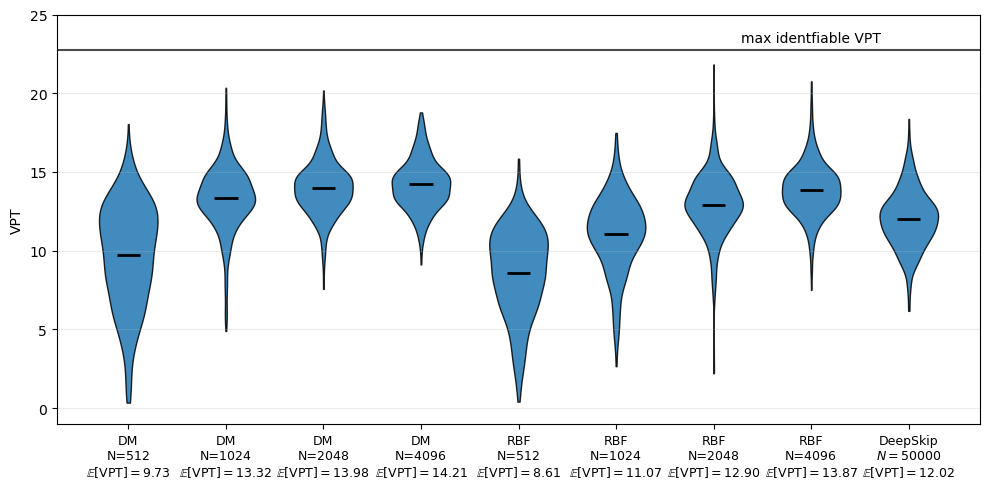

In [ ]:
import os
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

MAP_TYPE = "skip-connection"
RESULTS_DIR = "./numerical_results"

NUM_POINTS_WHITELIST = [512, 1024, 2048, 4096]

TITLE_PREFIX = "lorenz_3d_test_result_"
FNPAT = re.compile(
    r"^lorenz_3d_test_result_"
    r"(?P<mode>[^_]+)_(?P<map>[^_]+)_(?P<num>\d+)_cp_wonorm_nug_1000_training_shuflled\.pkl$"
)
MODE_ORDER = ["diffusion", "rbf"]
MODE_SHORT = {"diffusion": "DM", "rbf": "RBF"}

def discover_results(results_dir=RESULTS_DIR, whitelist=NUM_POINTS_WHITELIST, map_filter=None):
    """
    Scan results_dir for files matching the expected pattern.
    If map_filter is provided ('direct' or 'skip-connection'), only include those.
    """
    items = []
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    for fn in os.listdir(results_dir):
        if not fn.startswith(TITLE_PREFIX) or not fn.endswith(".pkl"):
            continue
        m = FNPAT.match(fn)
        if not m:
            continue
        mode = m.group("mode")
        map_type = m.group("map")
        num_points = int(m.group("num"))

        if map_filter is not None and map_type != map_filter:
            continue
        if whitelist and num_points not in whitelist:
            continue

        path = os.path.join(results_dir, fn)
        items.append((mode, map_type, num_points, path))

    if not items:
        flt = f" and map_type='{map_filter}'" if map_filter else ""
        raise RuntimeError(
            f"No files with N in {whitelist}{flt} found under pattern "
            f"'{TITLE_PREFIX}{{mode}}_{{map}}_{{num}}_cp_wonorm.pkl' in {results_dir}."
        )

    if map_filter:
        found_N = {n for *_, n, _ in items}
        missing = [n for n in whitelist if n not in found_N]
        if missing:
            warnings.warn(f"Requested N not found for map_type='{map_filter}': {missing}")
    return items

def load_perf(path):
    with open(path, "rb") as f:
        perf = pickle.load(f)
    vpts = np.asarray(perf["vpts"], dtype=float)
    tau  = np.asarray(perf["tau_fs"], dtype=float)
    return vpts, tau

def build_data_by_maptype(found):
    """
    data[map_type][mode][num_points] = (vpts, tau)
    """
    data = {}
    for mode, map_type, num_points, path in found:
        v, t = load_perf(path)
        print(f"mode = {mode}, map_type = {map_type}, N = {num_points} | vpt mean = {np.mean(v)}, vpt std = {np.std(v)}, max = {np.max(v)}, min = {np.min(v)}")
        data.setdefault(map_type, {}).setdefault(mode, {})[num_points] = (v, t)
    return data

def assemble_for_map(data_for_map, mode_order=MODE_ORDER, whitelist=NUM_POINTS_WHITELIST):
    """
    Returns (labels_base, vpt_list, tau_list) ordered by mode, then by whitelist.
    labels_base = ["DM\nN=1024", "DM\nN=2048", ...] (without means)
    """
    labels_base, vpt_list, tau_list = [], [], []
    for mode in mode_order:
        if mode not in data_for_map:
            continue
        Ns_available = data_for_map[mode].keys()
        Ns = [N for N in whitelist if N in Ns_available]
        for N in Ns:
            v, t = data_for_map[mode][N]
            short = MODE_SHORT.get(mode, mode)
            labels_base.append(f"{short}\nN={N}")
            vpt_list.append(v)
            tau_list.append(t)
    return labels_base, vpt_list, tau_list

def plot_vpt_for_maptype(map_type, labels_base, vpt_list, *,
                         digits=2, widths=0.6, color='C0',
                         logy=False, show_means_markers=True):
    
    n = len(labels_base)
    x = np.arange(1, n + 1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    vp = ax.violinplot(
        vpt_list,
        positions=x,
        widths=widths,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    for body in vp['bodies']:
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.85)
        body.set_linewidth(1)

    vpt_mean = np.array([np.nanmean(v) for v in vpt_list])
    if show_means_markers:
        for xi, mv in zip(x, vpt_mean):
            ax.hlines(
                mv,
                xi - 0.12,    # left endpoint
                xi + 0.12,    # right endpoint
                color='black',
                linewidth=2,
                zorder=5,
            )

    if logy:
        ax.set_yscale('log')
    ax.set_ylabel("VPT")

    # Tick labels: include E[VPT]
    labels_with_means = []
    for base, mv in zip(labels_base, vpt_mean):
        labels_with_means.append(
            f"{base}\n"
            r"$\mathbb{E}[\mathrm{VPT}]=" + f"{mv:.{digits}f}$"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(labels_with_means, rotation=0, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)

    yline = 25 * 0.91
    ax.axhline(
        y=yline,
        color="k",
        linewidth=1.5,
        alpha=0.7,
        linestyle="-"
    )
    ax.set_ylim([-1, 25])
    ax.text(
        8,                      # x in axis fraction (center)
        yline + 0.3,              # slightly above the line in data units
        "max identfiable VPT",
        ha="center",
        va="bottom",
        color="k",
    )

    fig.tight_layout()
    return fig

def load_deepskip_vpts(path=os.path.join(RESULTS_DIR, "deepskip_best_vpts.csv")):

    deepskip_vpts = np.loadtxt(path, delimiter=",")
    deepskip_vpts = np.ravel(deepskip_vpts)

    print(
        f"DeepSkip best: mean = {np.mean(deepskip_vpts)}, "
        f"std = {np.std(deepskip_vpts)}, "
        f"max = {np.max(deepskip_vpts)}, min = {np.min(deepskip_vpts)}"
    )
    return deepskip_vpts


def main(map_type: str, save=False, outdir="./pics", digits=2, logy=False):
    found = discover_results(map_filter=map_type)
    data = build_data_by_maptype(found)

    if map_type not in data:
        raise RuntimeError(f"No data found for map_type='{map_type}'")

    labels_base, vpt_list, tau_list = assemble_for_map(data[map_type])
    if not labels_base:
        raise RuntimeError(f"No plottable data for map_type='{map_type}'")

    try:
        deepskip_vpts = load_deepskip_vpts()
        labels_base.append("DeepSkip\n" +\
                            "$N = 50000$")
        vpt_list.append(deepskip_vpts)
    except OSError as e:
        print(f"Warning: could not load DeepSkip VPTs: {e}")

    fig = plot_vpt_for_maptype(
        map_type, labels_base, vpt_list,
        digits=digits, logy=logy, show_means_markers=True
    )

    fig.savefig(f"./journal_pics/lorenz_3d_violin_{map_type}.png",
                dpi=600, bbox_inches="tight", transparent=True)

    return fig

_ = main(MAP_TYPE, save=False, outdir="./pics", digits=2, logy=False)


In [12]:
with open("./numerical_results/lorenz_3d_test_result_diffusion_skip-connection_1024_vl_3000.pkl", "rb") as f:
    res = pickle.load(f)

vpts = res['vpts']
print(np.where(vpts==0.0))
print(np.sort(vpts))

(array([72]),)
[ 0.         3.3404644  4.0207804  4.5080672  4.6739602  5.7627388
  6.406309   6.683131   6.9328168  7.6892634  7.7324884  8.3564026
  8.8506964  8.9234236  9.5475926  9.8278726  9.936472   9.9385832
 10.247965  10.6309112 10.6407756 10.6711332 10.6751008 10.79442
 10.913903  10.9448794 11.0382272 11.1309016 11.1461896 11.1631702
 11.1791134 11.2465626 11.3475362 11.3823892 11.3870666 11.5345594
 11.5561264 11.556363  11.5746358 11.7079144 11.72353   11.732448
 11.763115  11.8605214 11.9284074 11.9772926 11.97742   11.9998606
 12.0147482 12.0670186 12.07388   12.08571   12.0859102 12.0927716
 12.100816  12.1370886 12.1497376 12.1634422 12.2162404 12.2236114
 12.2591924 12.2738798 12.2902962 12.2916612 12.3042192 12.3161948
 12.3308094 12.353978  12.3734156 12.3788938 12.3906328 12.453259
 12.4646704 12.4935174 12.512773  12.5699392 12.576746  12.5817692
 12.582479  12.615239  12.6270508 12.6382802 12.6387352 12.6522578
 12.68267   12.7048012 12.7091874 12.7186878 12.747

/tmp/ipykernel_2688628/4114972215.py:60: UserWarning: Requested N not found for map_type='skip-connection': [4096]
  warnings.warn(f"Requested N not found for map_type='{map_filter}': {missing}")


mode = rbf, map_type = skip-connection, N = 512 | vpt mean = 8.8680255664, vpt std = 1.7134096757541135, max = 11.703510000000001, min = 1.0469004
mode = diffusion, map_type = skip-connection, N = 2048 | vpt mean = 13.842137582000003, vpt std = 0.5932305260056118, max = 14.621334000000003, min = 9.5515602
mode = rbf, map_type = skip-connection, N = 1024 | vpt mean = 11.198573713600002, vpt std = 1.4246990039754779, max = 13.291405400000004, min = 1.8981326000000003
mode = diffusion, map_type = skip-connection, N = 512 | vpt mean = 11.028097225600002, vpt std = 2.4102515039345773, max = 13.9605466, min = 1.1885510000000001
mode = diffusion, map_type = skip-connection, N = 1024 | vpt mean = 13.181363176800001, vpt std = 1.252609506600418, max = 14.408721600000003, min = 3.7501828000000006
(array([], dtype=int64),)
DeepSkip best: mean = 12.0172, std = 1.8381852354972283, max = 18.37, min = 6.18


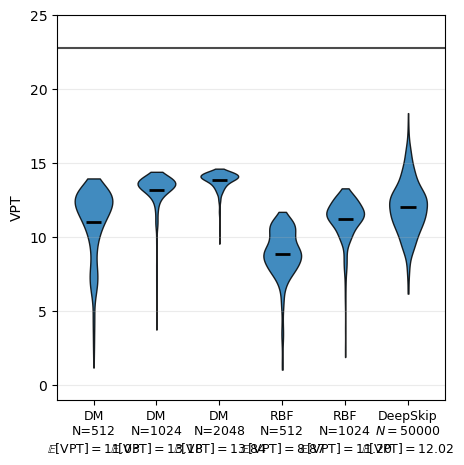

In [4]:
import os
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

map_type = "skip-connection"
results_dir = "./numerical_results"

num_points_lst = [512, 1024, 2048, 4096]


TITLE_PREFIX = "lorenz_3d_test_result_"
FNPAT = re.compile(
    r"^lorenz_3d_test_result_"
    r"(?P<mode>[^_]+)_(?P<map>[^_]+)_(?P<num>\d+)_vl_3000\.pkl$"
)
mode_lst = ["diffusion", "rbf"]
mode_label = {"diffusion": "DM", "rbf": "RBF"}

def discover_results(results_dir=results_dir, whitelist=num_points_lst, map_filter=None):
    """
    Scan results_dir for files matching the expected pattern.
    If map_filter is provided ('direct' or 'skip-connection'), only include those.
    """
    items = []
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")
    for fn in os.listdir(results_dir):
        if not fn.startswith(TITLE_PREFIX) or not fn.endswith(".pkl"):
            continue
        m = FNPAT.match(fn)
        if not m:
            continue
        mode = m.group("mode")
        map_type = m.group("map")
        num_points = int(m.group("num"))

        if map_filter is not None and map_type != map_filter:
            continue
        if whitelist and num_points not in whitelist:
            continue

        path = os.path.join(results_dir, fn)
        items.append((mode, map_type, num_points, path))

    if not items:
        flt = f" and map_type='{map_filter}'" if map_filter else ""
        raise RuntimeError(
            f"No files with N in {whitelist}{flt} found under pattern "
            f"'{TITLE_PREFIX}{{mode}}_{{map}}_{{num}}.pkl' in {results_dir}."
        )

    if map_filter:
        found_N = {n for *_, n, _ in items}
        missing = [n for n in whitelist if n not in found_N]
        if missing:
            warnings.warn(f"Requested N not found for map_type='{map_filter}': {missing}")
    return items

def load_perf(path):
    with open(path, "rb") as f:
        perf = pickle.load(f)
    vpts = np.asarray(perf["vpts"], dtype=float)
    tau  = np.asarray(perf["tau_fs"], dtype=float)
    return vpts, tau

def build_data_by_maptype(found):
    """
    data[map_type][mode][num_points] = (vpts, tau)
    """
    data = {}
    for mode, map_type, num_points, path in found:
        v, t = load_perf(path)
        print(f"mode = {mode}, map_type = {map_type}, N = {num_points} | vpt mean = {np.mean(v)}, vpt std = {np.std(v)}, max = {np.max(v)}, min = {np.min(v)}")
        data.setdefault(map_type, {}).setdefault(mode, {})[num_points] = (v, t)
    return data

def assemble_for_map(data_for_map, mode_order=mode_lst, whitelist=num_points_lst):
    """
    Returns (labels_base, vpt_list, tau_list) ordered by mode, then by whitelist.
    labels_base = ["DM\nN=1024", "DM\nN=2048", ...] (without means)
    """
    labels_base, vpt_list, tau_list = [], [], []
    for mode in mode_order:
        if mode not in data_for_map:
            continue
        Ns_available = data_for_map[mode].keys()
        Ns = [N for N in whitelist if N in Ns_available]
        for N in Ns:
            v, t = data_for_map[mode][N]
            short = mode_label.get(mode, mode)
            labels_base.append(f"{short}\nN={N}")
            if N == 1024 and mode == "diffusion":
                print(np.where(np.array(v)==0.0))
            vpt_list.append(v)
            tau_list.append(t)
    return labels_base, vpt_list, tau_list

def plot_vpt_for_maptype(map_type, labels_base, vpt_list, *,
                         digits=2, widths=0.6, color='C0',
                         logy=False, show_means_markers=True):
    
    n = len(labels_base)
    x = np.arange(1, n + 1)

    # fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    vp = ax.violinplot(
        vpt_list,
        positions=x,
        widths=widths,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    for body in vp['bodies']:
        body.set_facecolor(color)
        body.set_edgecolor('black')
        body.set_alpha(0.85)
        body.set_linewidth(1)

    vpt_mean = np.array([np.nanmean(v) for v in vpt_list])
    if show_means_markers:
        for xi, mv in zip(x, vpt_mean):
            ax.hlines(
                mv,
                xi - 0.12,    # left endpoint
                xi + 0.12,    # right endpoint
                color='black',
                linewidth=2,
                zorder=5,
            )

    if logy:
        ax.set_yscale('log')
    ax.set_ylabel("VPT")

    # Tick labels: include E[VPT]
    labels_with_means = []
    for base, mv in zip(labels_base, vpt_mean):
        labels_with_means.append(
            f"{base}\n"
            r"$\mathbb{E}[\mathrm{VPT}]=" + f"{mv:.{digits}f}$"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(labels_with_means, rotation=0, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)

    yline = 25 * 0.91
    ax.axhline(
        y=yline,
        color="k",
        linewidth=1.5,
        alpha=0.7,
        linestyle="-"
    )
    ax.set_ylim([-1, 25])
    # ax.text(
    #     8,                      # x in axis fraction (center)
    #     yline + 0.3,              # slightly above the line in data units
    #     "max identfiable VPT",
    #     ha="center",
    #     va="bottom",
    #     color="k",
    # )

    # fig.tight_layout()
    return fig

def load_deepskip_vpts(path=os.path.join('./numerical_results', "deepskip_best_vpts.csv")):

    deepskip_vpts = np.loadtxt(path, delimiter=",")
    deepskip_vpts = np.ravel(deepskip_vpts)

    print(
        f"DeepSkip best: mean = {np.mean(deepskip_vpts)}, "
        f"std = {np.std(deepskip_vpts)}, "
        f"max = {np.max(deepskip_vpts)}, min = {np.min(deepskip_vpts)}"
    )
    return deepskip_vpts


digits=2
logy=False

found = discover_results(map_filter=map_type)
data = build_data_by_maptype(found)

if map_type not in data:
    raise RuntimeError(f"No data found for map_type='{map_type}'")

labels_base, vpt_list, tau_list = assemble_for_map(data[map_type])
if not labels_base:
    raise RuntimeError(f"No plottable data for map_type='{map_type}'")

try:
    deepskip_vpts = load_deepskip_vpts()
    labels_base.append("DeepSkip\n" +\
                        "$N = 50000$")
    vpt_list.append(deepskip_vpts)
except OSError as e:
    print(f"Warning: could not load DeepSkip VPTs: {e}")

fig = plot_vpt_for_maptype(
    map_type, labels_base, vpt_list,
    digits=digits, logy=logy, show_means_markers=True
)

# fig.savefig(f"./journal_pics/lorenz_3d_violin_{map_type}.png",
#             dpi=600, bbox_inches="tight", transparent=True)



# _ = main(MAP_TYPE, save=False, outdir="./pics", digits=2, logy=False)


In [34]:
import numpy as np
num_points = 10 #1024
np.set_printoptions(precision=16)
train = np.load("./cached_data/lorenz_train.npy").T
X1 = train[:num_points, :]
# X1 = np.array(train[:num_points, :], order='C')
# X2 = np.array(train[:num_points, :], order='F')
X2 = train[:num_points, :].copy(order='F')

X1 = np.sum(X1, axis=0).reshape(-1,1)
X2 = np.sum(X2, axis=0).reshape(-1,1)

print("Contiguity:", X1.flags['C_CONTIGUOUS'], X2.flags['C_CONTIGUOUS'])
print("Same memory buffer:", X1.base is train, X2.base is train)

AX = 0
print("Mean diff:", np.abs(X1.mean(axis=AX) - X2.mean(axis=AX)))
print("Std diff :", np.abs(X1.std(axis=AX)  - X2.std(axis=AX)))
print("Max abs diff:", np.max(np.abs(X1 - X2)))

Contiguity: True True
Same memory buffer: False False
Mean diff: [0.]
Std diff : [0.]
Max abs diff: 0.0


In [5]:
import general_utils
import cupy as cp
import numpy as np
import polars as pl
import pickle

num_points = 4096
devices = 4
dt = 0.01
cv_trials_per_device = 1024
mode_list = ["diffusion", "rbf"]
map_type_lst = ['skip-connection']

validation_repeats = 20
error_threshold = 0.3 ** 2
test = np.load('./cached_data/lorenz_test.npy').transpose(0, 2, 1)

title = f"lorenz_3d"

# Datasets 
train = np.load("./cached_data/lorenz_train.npy").T

def get_params():

    path = f"numerical_results/{title}_cv_result_{mode}_{num_points}_{map_type}_cp_wonorm_nug_1000.parquet"

    cv_results = pl.read_parquet(path)

    epsilon_array_loc = cv_results["epsilon"].to_numpy()
    lambda_reg_array_loc = cv_results["lambda"].to_numpy()
    try:
        score = cv_results["tau_f"].to_numpy()
        argfunc = np.nanargmax
    except Exception:
        score = cv_results["rmse"].to_numpy()
        argfunc = np.nanargmin

    best_idx = argfunc(score)
    # print(f"selected objective = {score[best_idx]}")
    best_epsilon = epsilon_array_loc[best_idx]
    best_lambda_reg = lambda_reg_array_loc[best_idx]
    return best_epsilon, best_lambda_reg, score[best_idx]

idx = 0
mode = 'diffusion'

for map_type in map_type_lst:
    opts = {
    "map_type": map_type,
    "norm": False,
    }
    
    test_file = f"./numerical_results/{title}_test_result_{mode}_{map_type}_{num_points}_cp_wonorm_nug_1000_training_shuflled.pkl"

    with open(test_file, "rb") as f:
        performance = pickle.load(f)

    vpts = performance["vpts"]
    # best_idx = np.argmax(vpts)
    idx = 0
    training_data = performance["train_data"][idx]
    opts['data'] = training_data

    best_epsilon, best_lambda_reg, best_tauf = get_params()
    model = general_utils.modeler(**opts)
    model.fit_model(best_epsilon, best_lambda_reg, mode, k=None)
    vpt, tau_f, pred = model.get_vpt(
            test[idx], dt=dt, Lyapunov_time=1 / 0.91, error_threshold=error_threshold, return_pred=True
        )
    pred = cp.asnumpy(pred)


In [6]:
i_train = train[:4096, :].copy()
opts['data'] = i_train
model = general_utils.modeler(**opts)
model.fit_model(best_epsilon, best_lambda_reg, mode, k=None)

In [ ]:
kernel_matrix = cp.asnumpy(model.dm.kernel_matrix)
q2 = cp.asnumpy(model.dm.q2)

eig, eigv = np.linalg.eig(kernel_matrix)
eig = eig.real
eigv = eigv.real

phi = (q2.reshape(-1, 1))**(0.5) * eigv

In [9]:
np.log(eig[:10].real)/best_epsilon

array([0.01939362, 0.0150398 , 0.01369474, 0.01011741, 0.00988655,
       0.00710686, 0.00680058, 0.00340101, 0.0029544 , 0.0021242 ])

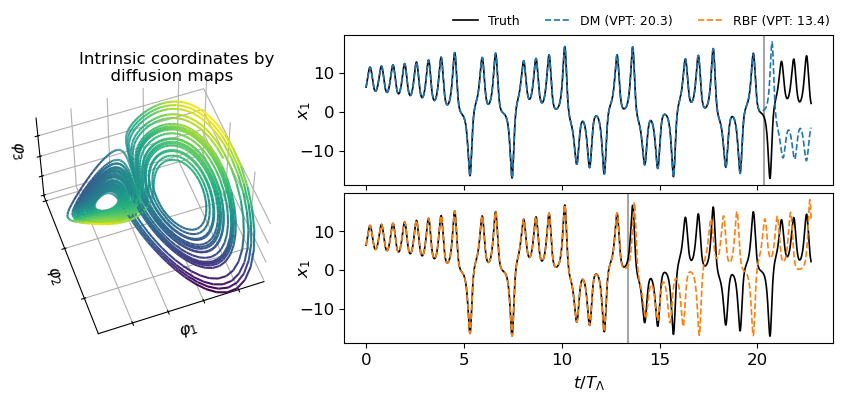

In [67]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize
import pickle

num_points = 1024
dt = 0.01
T = 2500
Lyapunov_exp = 0.91
t = np.arange(0, T)*dt
t_scaled = t * Lyapunov_exp
state_idx = 0

mode_lst = ['diffusion', 'rbf']
preds = {'diffusion': [],
         'rbf': []}
vpts = {'diffusion': [],
         'rbf': []}

for mode in mode_lst:
    outp = (
            f'./numerical_results/lorenz_3d_test_result_{mode}_skip-connection_{num_points}_cp_wonorm_nug_1000_training_shuflled.pkl'
        )
    with open(outp, 'rb') as f:
        performance = pickle.load(f)
    preds[mode] = performance['preds']
    vpts[mode] = performance['vpts']

idx = np.argmax(vpts["diffusion"])
test = np.load('./cached_data/lorenz_test.npy').transpose(0, 2, 1)
truePath = test[idx]

COL_TRUE = "#000000"
COL_DM   = "#1f77b4"
COL_RBF  = "#ff7f0e"
COL_VPT  = "grey"

PE_OUTLINE = [pe.withStroke(linewidth=2.0, foreground="white")]


fig = plt.figure(figsize=(12, 4))
outer_gs = fig.add_gridspec(
    nrows=1,
    ncols=2,
    wspace=-0.10,
)

left_gs = outer_gs[0, 0].subgridspec(
    nrows=2,
    ncols=1,
    height_ratios=[0.25, 18.0],
)

ax_3d = fig.add_subplot(left_gs[1, 0], projection="3d")

right_gs = outer_gs[0, 1].subgridspec(
    nrows=2,
    ncols=1,
    hspace=0.05,
)

ax_dm  = fig.add_subplot(right_gs[0, 0])
ax_rbf = fig.add_subplot(right_gs[1, 0])


X = eig[1:4].reshape(1, -1) * phi[:, 1:4]
X = X.real
points = X.reshape(-1, 1, 3)
X = X.T
segments = np.concatenate([points[:-1], points[1:]], axis=1)

icmap = plt.get_cmap("viridis")
norm = Normalize(vmin=X[2].min(), vmax=X[2].max())
lc_full = Line3DCollection(segments, cmap=icmap, norm=norm)
lc_full.set_array(X[2][:-1])
ax_3d.add_collection3d(lc_full)
ax_3d.set_xlim(X[0].min(), X[0].max())
ax_3d.set_ylim(X[1].min(), X[1].max())
ax_3d.set_zlim(X[2].min(), X[2].max())
ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])
ax_3d.set_facecolor("white")   
for axis in (ax_3d.xaxis, ax_3d.yaxis, ax_3d.zaxis):
    axis.pane.set_facecolor("white")
    axis.pane.set_edgecolor("white") 
ax_3d.set_xlabel(r'$\varphi_1$', fontsize=12, labelpad=-10)
ax_3d.set_ylabel(r'$\varphi_2$', fontsize=12, labelpad=-10)
ax_3d.set_zlabel(r'$\varphi_3$', fontsize=12, labelpad=-10)
ax_3d.text2D(
    0.25, 0.95,
    "Intrinsic coordinates by \n      diffusion maps",
    transform=ax_3d.transAxes,
    fontsize=12,
    color="black",
)
ax_3d.view_init(elev=55, azim=-110)


line_truth, = ax_dm.plot(
    t_scaled, truePath[:, state_idx],
    color=COL_TRUE, linestyle="-", linewidth=1.2, label="Truth"
)
line_dm, = ax_dm.plot(
    t_scaled, preds['diffusion'][idx][:, state_idx],
    color=COL_DM, linestyle="--", linewidth=1.2, label=f"DM (VPT = {vpts['diffusion'][idx]:.1f})"
)

ax_dm.axvline(
    x=vpts['diffusion'][idx], color=COL_VPT,
    alpha=0.7, linewidth=1.5, zorder=1
)
ax_dm.set_xticklabels([])
ax_dm.set_ylabel(r"$x_1$", fontsize=12, labelpad=-10)

ax_rbf.plot(
    t_scaled, truePath[:, state_idx],
    color=COL_TRUE, linestyle="-", linewidth=1.2, label="Truth"
)
line_rbf, = ax_rbf.plot(
    t_scaled, preds['rbf'][idx][:, state_idx],
    color=COL_RBF, linestyle="--", linewidth=1.2, label=f"RBF (VPT = {vpts['rbf'][idx]:.1f})"
)

ax_rbf.axvline(
    x=vpts['rbf'][idx], color=COL_VPT,
    alpha=0.7, linewidth=1.5, zorder=1
)

ax_rbf.set_ylabel(r"$x_1$", fontsize=12, labelpad=-10)
ax_rbf.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)

handles = [line_truth, line_dm, line_rbf]
labels  = ["Truth", f"DM (VPT: {vpts['diffusion'][idx]:.1f})", f"RBF (VPT: {vpts['rbf'][idx]:.1f})"]

fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.74, 0.96),
    frameon=False,
    fontsize=9,
)

fig.savefig("./journal_pics/lorenz_predictions.png",
            bbox_inches="tight", dpi=600, transparent=True)


In [3]:
X1 = train[:num_points, :]
X2 = train[:num_points, :].copy()

print("Contiguity:", X1.flags['C_CONTIGUOUS'], X2.flags['C_CONTIGUOUS'])
print("Same memory buffer:", X1.base is train, X2.base is train)

print("Mean diff:", np.abs(X1.mean(axis=0) - X2.mean(axis=0)))
print("Std diff :", np.abs(X1.std(axis=0)  - X2.std(axis=0)))
print("Max abs diff:", np.max(np.abs(X1 - X2)))

Contiguity: False True
Same memory buffer: False False
Mean diff: [5.32907052e-15 0.00000000e+00 3.55271368e-15]
Std diff : [1.77635684e-15 7.10542736e-15 5.32907052e-15]
Max abs diff: 0.0


In [2]:
import pickle
import numpy as np
import cupy as cp
import general_utils
import polars as pl


num_points = 1024
dt = 0.01
T = 2500
Lyapunov_exp = 0.91
t = np.arange(0, T)*dt
t_scaled = t * Lyapunov_exp
state_idx = 0
map_type = 'skip-connection'

def get_params():

    path = f"numerical_results/lorenz_3d_cv_result_{mode}_{num_points}_{map_type}_cp_wonorm_nug_1000.parquet"
    cv_results = pl.read_parquet(path)

    epsilon_array_loc = cv_results["epsilon"].to_numpy()
    lambda_reg_array_loc = cv_results["lambda"].to_numpy()
    score = cv_results["tau_f"].to_numpy()
    argfunc = np.nanargmax

    best_idx = argfunc(score)
    best_epsilon = epsilon_array_loc[best_idx]
    best_lambda_reg = lambda_reg_array_loc[best_idx]
    return best_epsilon, best_lambda_reg, score[best_idx]

mode_lst = ['diffusion', 'rbf']
lz_trains = {'diffusion': [],
         'rbf': []}
lz_preds = {'diffusion': [],
         'rbf': []}
lz_true = {'diffusion': [],
         'rbf': []}
lz_vpts = {'diffusion': [],
         'rbf': []}

test = np.load('./cached_data/lorenz_test.npy').transpose(0, 2, 1)

for mode in mode_lst:
    test_file = f"./numerical_results/lorenz_3d_test_result_{mode}_{map_type}_{num_points}_cp_wonorm_nug_1000_training_shuflled.pkl"

    with open(test_file, "rb") as f:
        performance = pickle.load(f)

    lz_preds[mode] = performance['preds']
    lz_true[mode] = test
    lz_trains[mode] = performance['train_data']
    lz_vpts[mode] = performance['vpts']
    

lz_train = np.load("./cached_data/lorenz_train.npy").T
lz_test = np.load('./cached_data/lorenz_test.npy').transpose(0, 2, 1)


best_epsilon, best_lambda_reg, best_tauf = get_params()
opts = {
    "map_type": map_type,
    "norm": False,
    }
nug = 5000
opts['data'] = lz_train[nug:nug+4096, :].copy()
model = general_utils.modeler(**opts)
model.fit_model(best_epsilon, best_lambda_reg, "diffusion", k=None)

kernel_matrix = cp.asnumpy(model.dm.kernel_matrix)
q2 = cp.asnumpy(model.dm.q2)

eig, eigv = np.linalg.eig(kernel_matrix)
eig = eig.real
eigv = eigv.real

phi = (q2.reshape(-1, 1))**(0.5) * eigv

In [16]:
import os
import re
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import polars as pl
import general_utils
import cupy as cp

NT = 15_000_000
SKP = 500_000
DT = 0.01
TS = 10
data = pickle.load(open(f"./ks_utils/ksdata_chaotic_training_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]
xx = data["x"]
uu = data["udata"].astype(np.float64)
Nx, Nt = len(xx), len(data["t"])
assert uu.shape == (Nt, Nx)

num_points = 8192
steps = 2500
test_trials = 500

data_train = np.ascontiguousarray(uu[:num_points])

NT = 12_500_000
SKP = 500_000
DT = 0.01
TS = 10
test_load = pickle.load(open(f"./ks_utils/ksdata_chaotic_test_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
uu_test = test_load["udata"].astype(np.float64)
ks_test = uu_test[:steps*test_trials].reshape(test_trials, steps, -1)

mode_lst = ['diffusion', 'rbf']
results = {}
for mode in mode_lst:
    results[mode] = {}


ks_idx = 93
for mode in mode_lst:
    map_type = "direct"
    filename = f"./numerical_results/ks_chaotic_test_result_{mode}_{map_type}_{num_points}.pkl"

    with open(filename, "rb") as f:
        results_df = pickle.load(f)

    ks_vpts = results_df['vpts']
    ks_pred_path = results_df["preds"][ks_idx]
    
    results[mode]['truth'] = ks_test[ks_idx]
    results[mode]['path'] = ks_pred_path
    results[mode]['error'] = np.abs(ks_test[ks_idx] - ks_pred_path)
    results[mode]['vpt'] = ks_vpts[ks_idx]


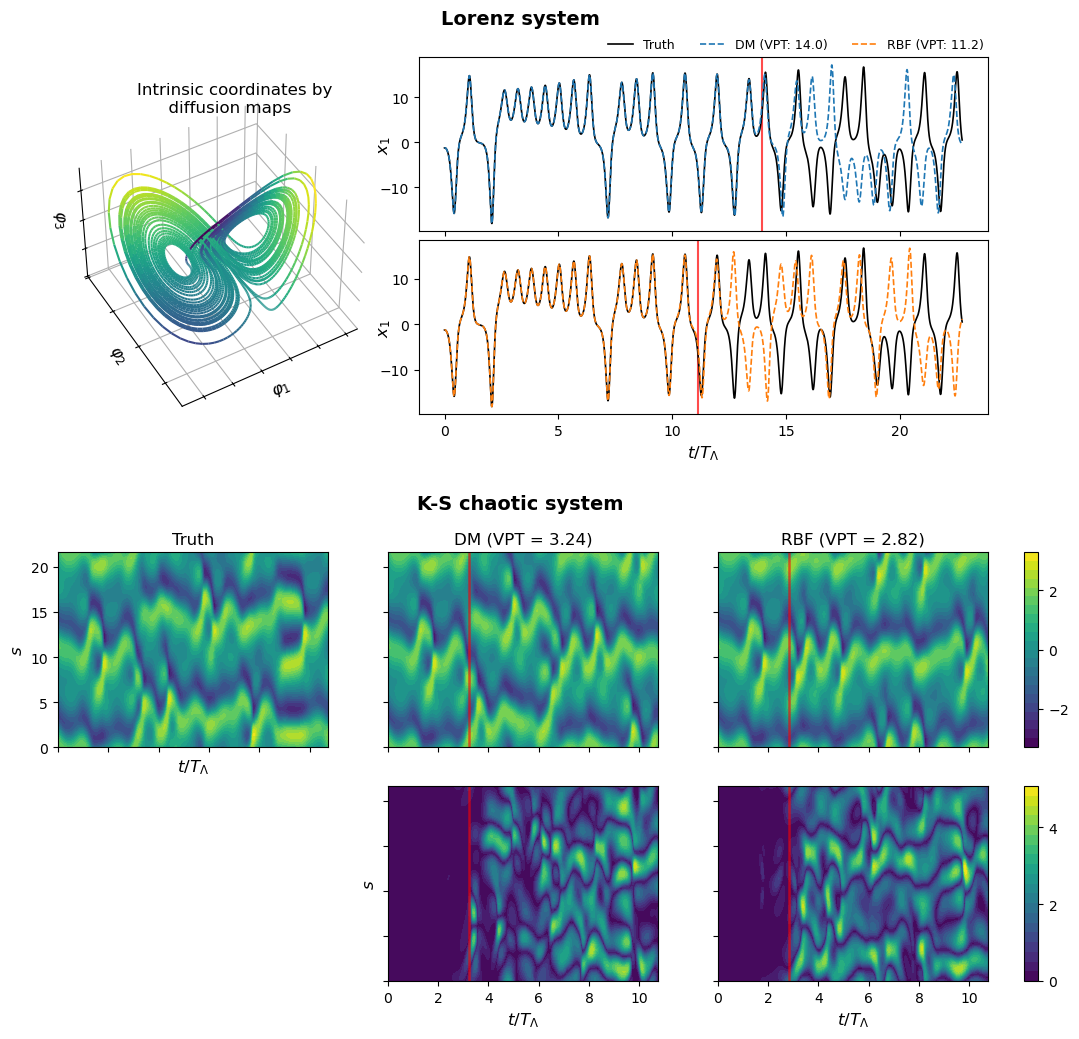

In [17]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

PE_OUTLINE = [pe.withStroke(linewidth=2.0, foreground="white")]

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.012):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom, top = min(bottoms), max(tops)
    height = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

def prettify_cbar(cb, nbins=6, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.update_ticks()

fig = plt.figure(figsize=(12, 12))

'''
    Lorenz system
'''

lz_idx = 2
truePath = lz_test[lz_idx]

outer_gs = fig.add_gridspec(
    nrows=2,
    ncols=1,
    height_ratios=[1.0, 1.2],
    hspace=0.35,
)

lorenz_outer = outer_gs[0, 0].subgridspec(
    nrows=1,
    ncols=2,
    width_ratios=[1.0, 1.8],
    wspace=0.1,
)

# Left side of Lorenz block: 3D plot shifted downward
lorenz_left = lorenz_outer[0, 0].subgridspec(
    nrows=2,
    ncols=1,
    height_ratios=[0.25, 18.0],
)

ax_3d = fig.add_subplot(lorenz_left[1, 0], projection="3d")

# Right side: DM / RBF time series
lorenz_right = lorenz_outer[0, 1].subgridspec(
    nrows=2,
    ncols=1,
    hspace=0.05,
)

ax_dm_lorenz  = fig.add_subplot(lorenz_right[0, 0])
ax_rbf_lorenz = fig.add_subplot(lorenz_right[1, 0])


X = eig[1:4].reshape(1, -1) * phi[:, 1:4]
X = X.real
points = X.reshape(-1, 1, 3)
X = X.T
segments = np.concatenate([points[:-1], points[1:]], axis=1)

icmap = plt.get_cmap("viridis")
norm = Normalize(vmin=X[2].min(), vmax=X[2].max())
lc_full = Line3DCollection(segments, cmap=icmap, norm=norm)
lc_full.set_array(X[2][:-1])
ax_3d.add_collection3d(lc_full)
ax_3d.set_xlim(X[0].min(), X[0].max())
ax_3d.set_ylim(X[1].min(), X[1].max())
ax_3d.set_zlim(X[2].min(), X[2].max())
ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])
ax_3d.set_facecolor("white")
for axis in (ax_3d.xaxis, ax_3d.yaxis, ax_3d.zaxis):
    axis.pane.set_facecolor("white")
    axis.pane.set_edgecolor("white")
ax_3d.set_xlabel(r'$\varphi_1$', fontsize=12, labelpad=-10)
ax_3d.set_ylabel(r'$\varphi_2$', fontsize=12, labelpad=-10)
ax_3d.set_zlabel(r'$\varphi_3$', fontsize=12, labelpad=-10)
ax_3d.text2D(
    0.25, 0.95,
    "Intrinsic coordinates by \n      diffusion maps",
    transform=ax_3d.transAxes,
    fontsize=12,
    color="black",
)
ax_3d.view_init(elev=45, azim=-120)


COL_TRUE = "#000000"
COL_DM   = "#1f77b4"
COL_RBF  = "#ff7f0e"
COL_VPT  = "r"

idx = 2
line_truth, = ax_dm_lorenz.plot(
    t_scaled, truePath[:, state_idx],
    color=COL_TRUE, linestyle="-", linewidth=1.2, label="Truth"
)
line_dm, = ax_dm_lorenz.plot(
    t_scaled, lz_preds['diffusion'][idx][:, state_idx],
    color=COL_DM, linestyle="--", linewidth=1.2,
    label=f"DM (VPT = {lz_vpts['diffusion'][idx]:.1f})"
)
ax_dm_lorenz.axvline(
    x=lz_vpts['diffusion'][idx], color=COL_VPT,
    alpha=0.7, linewidth=1.5, zorder=1
)
ax_dm_lorenz.set_xticklabels([])
ax_dm_lorenz.set_ylabel(r"$x_1$", fontsize=12, labelpad=-10)

ax_rbf_lorenz.plot(
    t_scaled, truePath[:, state_idx],
    color=COL_TRUE, linestyle="-", linewidth=1.2, label="Truth"
)
line_rbf, = ax_rbf_lorenz.plot(
    t_scaled, lz_preds['rbf'][idx][:, state_idx],
    color=COL_RBF, linestyle="--", linewidth=1.2,
    label=f"RBF (VPT = {lz_vpts['rbf'][idx]:.1f})"
)
ax_rbf_lorenz.axvline(
    x=lz_vpts['rbf'][idx], color=COL_VPT,
    alpha=0.7, linewidth=1.5, zorder=1
)
ax_rbf_lorenz.set_ylabel(r"$x_1$", fontsize=12, labelpad=-10)
ax_rbf_lorenz.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)

handles = [line_truth, line_dm, line_rbf]
labels  = ["Truth",
           f"DM (VPT: {lz_vpts['diffusion'][idx]:.1f})",
           f"RBF (VPT: {lz_vpts['rbf'][idx]:.1f})"]

fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.74, 0.905),
    frameon=False,
    fontsize=9,
)

fig.text(
    0.51, 0.92,
    "Lorenz system",
    ha="center", va="top",
    fontsize=14, fontweight="bold",
)

ks_gs  = outer_gs[1, 0].subgridspec(
    nrows=2,
    ncols=3,
    hspace=0.20,
    wspace=0.22,
)


'''
    K-S chaotic system
'''


dt_ks = 0.1
steps_ks = 2500
lye_ks = 0.043
t_ks = np.linspace(0, dt_ks*(steps_ks-1), steps_ks) * lye_ks

ax_truth_ks    = fig.add_subplot(ks_gs[0, 0])
ax_dm_ks       = fig.add_subplot(ks_gs[0, 1], sharex=ax_truth_ks, sharey=ax_truth_ks)
ax_rbf_ks      = fig.add_subplot(ks_gs[0, 2], sharex=ax_truth_ks, sharey=ax_truth_ks)

ax_dm_err_ks   = fig.add_subplot(ks_gs[1, 1], sharex=ax_truth_ks, sharey=ax_truth_ks)
ax_rbf_err_ks  = fig.add_subplot(ks_gs[1, 2], sharex=ax_truth_ks, sharey=ax_truth_ks)


im_truth = ax_truth_ks.contourf(t_ks, xx, results['diffusion']['truth'].T, levels=21)
truth_levels = im_truth.levels
im_dm_ks  = ax_dm_ks.contourf(t_ks, xx, results['diffusion']['path'].T, levels=truth_levels)
im_rbf_ks = ax_rbf_ks.contourf(t_ks, xx, results['rbf']['path'].T,       levels=truth_levels)

err_dm = np.sqrt(np.mean((results['diffusion']['path'] - results['diffusion']['truth'])**2))
err_rbf = np.sqrt(np.mean((results['rbf']['path'] - results['diffusion']['truth'])**2))


ax_truth_ks.set_title('Truth')
ax_dm_ks.set_title(f"DM (VPT = {results['diffusion']['vpt']:.2f})")
ax_rbf_ks.set_title(f"RBF (VPT = {results['rbf']['vpt']:.2f})")

err_arrays = [
    np.asarray(results['diffusion']['error']),
    np.asarray(results['rbf']['error'])
]
vmax_err = max(float(np.nanmax(e)) for e in err_arrays if e.size)
levels_err = np.linspace(0, vmax_err, 21)
im_dm_err_ks  = ax_dm_err_ks.contourf(t_ks, xx, results['diffusion']['error'].T, levels=levels_err)
im_rbf_err_ks = ax_rbf_err_ks.contourf(t_ks, xx, results['rbf']['error'].T,       levels=levels_err)

axes_shared = [
    ax_truth_ks,
    ax_dm_ks, ax_rbf_ks,
    ax_dm_err_ks, ax_rbf_err_ks,
]
for ax in axes_shared:
    ax.set_xlim(ax_truth_ks.get_xlim())
    ax.set_ylim(ax_truth_ks.get_ylim())
    ax.set_autoscale_on(False)
    ax.label_outer()

ax_truth_ks.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)
ax_truth_ks.set_ylabel(r"$s$", fontsize=12)
ax_dm_err_ks.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)
ax_dm_err_ks.set_ylabel(r"$s$", fontsize=12)
ax_rbf_err_ks.set_xlabel(r"$t / T_{\Lambda}$", fontsize=12)

COL_VPT  = "r"

x_dm_vpt   = results['diffusion']['vpt']
x_rbf_vpt  = results['rbf']['vpt']

for ax in (ax_dm_ks, ax_dm_err_ks):
    ax.axvline(x=x_dm_vpt,  color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)

for ax in (ax_rbf_ks, ax_rbf_err_ks):
    ax.axvline(x=x_rbf_vpt,  color=COL_VPT, alpha=0.6, linewidth=1.8, zorder=1)

row2_axes = [ax_dm_ks, ax_rbf_ks]
row3_axes = [ax_dm_err_ks, ax_rbf_err_ks]

cb1 = add_row_colorbar(fig, row2_axes, im_dm_ks,   left=0.93, width=0.012)
cb2 = add_row_colorbar(fig, row3_axes, im_dm_err_ks, left=0.93, width=0.012)

prettify_cbar(cb1, nbins=5)
prettify_cbar(cb2, nbins=5)


fig.text(
    0.51, 0.5,
    "K-S chaotic system",
    ha="center", va="bottom",
    fontsize=14, fontweight="bold",
)

fig.savefig("./journal_pics/combined_lorenz_ks.png", bbox_inches="tight", dpi=600, transparent=True)

# Sensitivity Study for validation length

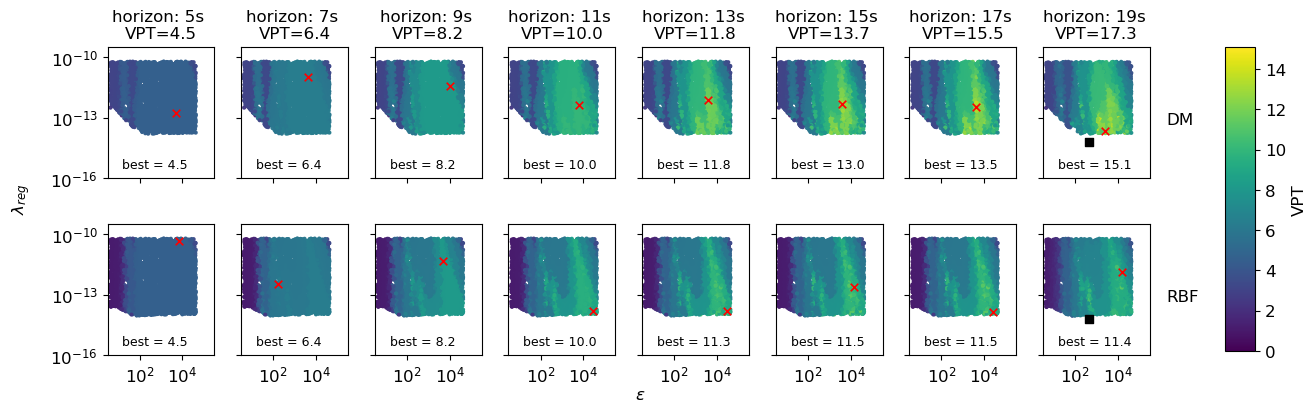

In [ ]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl
np.random.seed(42)

RESULTS_DIR = "numerical_results"
TITLE = "lorenz_3d"

N = 512

ROW_ORDER = [
    ("diffusion", "skip-connection"),
    ("rbf",       "skip-connection"),
]
MODE_LABEL = {"diffusion": "DM", "rbf": "RBF"}

cmap = "viridis"
point_size = 4
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

validation_horizon_lst = [200*i+500 for i in range(8)]


cv_data = {}
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

for mode, map_type in ROW_ORDER:
    for validation_horizon in validation_horizon_lst:
        def cv_path(mode: str, N: int, map_type: str) -> str:
            return os.path.join(RESULTS_DIR, f"lorenz_3d_cv_result_{mode}_{N}_{map_type}_vl_{2*validation_horizon}.pkl")
        fp = cv_path(mode, N, map_type)
        if not os.path.exists(fp):
            print("File does not exist")
            continue
        try:
            with open(fp, "rb") as f:
                df = pickle.load(f)
        except Exception as e:
            print(f"[WARN] failed to read {fp}: {e}")
            continue
        _idx = 0
        eps = df["epsilon"][_idx]
        lam = df["lambda"][_idx]
        vpt = df["vpt"][_idx]

        # print(f"mode = {mode}, map_type = {map_type}, N = {N}, maxvpt = {np.max(vpt)}")

        lamm = df["lambda_min"][_idx]
        epsc = df["epsilon_c"][_idx]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )

        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, validation_horizon)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))

if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid VPT values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)


def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(ROW_ORDER), len(validation_horizon_lst)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13
CBAR_W  = 0.028
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)


sc_last = None

for r, (mode, map_type) in enumerate(ROW_ORDER):
    for c, validation_horizon in enumerate(validation_horizon_lst):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"horizon: {int(validation_horizon*0.01):d}s \nVPT={validation_horizon*0.91*0.01:2.1f}", fontsize=12)

        if c == cols - 1:
            ax.set_ylabel(f"{MODE_LABEL[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, validation_horizon)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        eps_c = D["epsc"]
        lam_m = D["lamm"]

        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        max_vpt = vpt_v.max()                # or np.max(a)
        max_indices = np.argwhere(vpt_v == max_vpt)
        max_v = vpt_v[max_indices]
        max_eps = eps_v[max_indices]
        max_lam = lam_v[max_indices]

        picked_index = np.random.randint(len(max_v))
        best_vpt = max_v[picked_index][0]
        best_eps= max_eps[picked_index]
        best_lam = max_lam[picked_index]


        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, lam_m, c="black", marker='s', s=30)
        sc_last = sc

        # idx = np.nanargmax(vpt_v)
        # best_eps = eps_v[idx]
        # best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(0.5), 10**(5.5)])
        ax.set_ylim(10**(-16), 10**(-9.5))

        ax.text(10**(1.2), 10**(-15.5), f"best = {best_vpt:2.1f}", fontsize=9)

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.00, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(rows):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(cols):
    ax = axs[1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

# fig.savefig("./journal_pics/lorenz_sensitivity_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)


N = 512, mode = diffusion, vl = 500: min VPT = 1.1349338, mean VPT = 7.786347550800001
N = 512, mode = diffusion, vl = 700: min VPT = 1.1349338, mean VPT = 8.506456176399999
N = 512, mode = diffusion, vl = 900: min VPT = 1.1885510000000001, mean VPT = 9.564075102400002
N = 512, mode = diffusion, vl = 1100: min VPT = 1.1885510000000001, mean VPT = 10.4724488232
N = 512, mode = diffusion, vl = 1300: min VPT = 1.1885510000000001, mean VPT = 10.945106244800002
N = 512, mode = diffusion, vl = 1500: min VPT = 1.1885510000000001, mean VPT = 11.028097225600002
N = 512, mode = diffusion, vl = 1700: min VPT = 1.8391282000000004, mean VPT = 11.023927460000003
N = 512, mode = diffusion, vl = 1900: min VPT = 1.8391282000000004, mean VPT = 10.9807760608
N = 512, mode = rbf, vl = 500: min VPT = 0.9641996000000002, mean VPT = 6.550182657200001
N = 512, mode = rbf, vl = 700: min VPT = 0.9641996000000002, mean VPT = 7.508597387200001
N = 512, mode = rbf, vl = 900: min VPT = 1.0469004, mean VPT = 8.44633

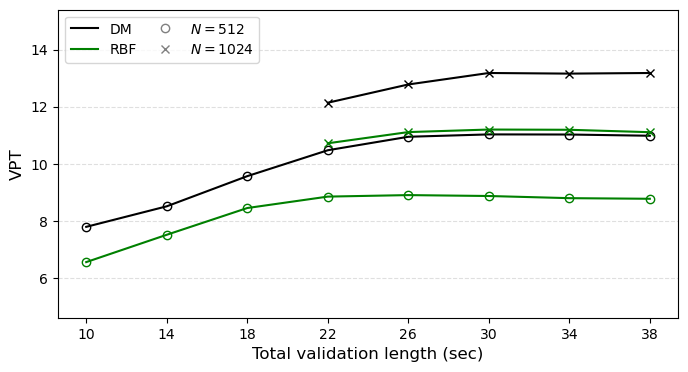

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import os
from matplotlib.lines import Line2D


validation_horizon_dict = {
    '512': [200*i+500 for i in range(8)],
    '1024': [200*i+1100 for i in range(5)]
}
mode_lst = ['diffusion', 'rbf']
map_type = "skip-connection"

num_points_lst = [512, 1024]
mode_labels = ['DM', 'RBF']
fig, ax = plt.subplots(figsize=(8, 4))
horizons = np.arange(1, len(validation_horizon_dict['512']) + 1)
mode_to_color = {"diffusion": "black", "rbf": "green"}
mode_to_shape = {"512": "o-", "1024": "x-"}


ls = []
for i, num_points in enumerate(num_points_lst):
    vpt_dict = {
        'diffusion': [],
        'rbf': [],
    }
    for mode in mode_lst:
        validation_horizon_lst = validation_horizon_dict[str(num_points)]
        for validation_horizon in validation_horizon_lst:

            test_file = f"./numerical_results/lorenz_3d_test_result_{mode}_{map_type}_{num_points}_vl_{2*validation_horizon}.pkl"
            if not os.path.exists(test_file):
                vpt_dict[mode].append([0])
                print(f"File ({test_file}) does not exist")
                continue
            
            with open(test_file, "rb") as f:
                performance = pickle.load(f)

            vpts = performance["vpts"] 
            vpt_dict[mode].append(vpts)
            print(f"N = {num_points}, mode = {mode}, vl = {validation_horizon}: min VPT = {np.min(vpts)}, mean VPT = {np.mean(vpts)}")

        means = np.array([np.array(arr).mean() for arr in vpt_dict[mode]])
        stds  = np.array([np.array(arr).std(ddof=1) for arr in vpt_dict[mode]])

        # fmt = mode_to_shape[str(num_points)]
        # kwargs = dict(capsize=4, color=mode_to_color[mode])
        # if num_points == 1024:
        #     kwargs.update(markerfacecolor="none",
        #                 markeredgecolor=mode_to_color[mode],
        #                 markeredgewidth=1.5)
        # _l = ax.errorbar(validation_horizon_lst, means, fmt=fmt, **kwargs)

        _l = ax.errorbar(
            validation_horizon_lst,
            means,
            fmt=mode_to_shape[str(num_points)],
            markerfacecolor="none",
            capsize=4,
            color=mode_to_color[mode]
        )
        if num_points == num_points_lst[0]:
            ls.append(_l)

        
        

ax.set_xticks(validation_horizon_dict['512'])
ax.set_xticklabels([f"{int(2*0.01*v):d}" for v in validation_horizon_dict['512']])
ax.set_xlabel("Total validation length (sec)", fontsize=12)
ax.set_ylabel("VPT", fontsize=12)
ax.set_ylim([4.6, 15.4])
ax.grid(axis="y", linestyle="--", alpha=0.4)
model_handles = [
    Line2D([0], [0], color='black', linestyle='-', label='DM'),
    Line2D([0], [0], color='green', linestyle='-', label='RBF'),
]

n_handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='none', markerfacecolor='none', label=r'$N=512$'),
    Line2D([0], [0], color='gray', marker='x', linestyle='none', label=r'$N=1024$'),
]

# combine
handles = model_handles + n_handles
labels  = [h.get_label() for h in handles]

leg = ax.legend(
    handles, labels,
    ncol=2,
    loc='upper left',
    columnspacing=1.0,
    handlelength=2.0,
)

fig.savefig(f"./journal_pics/lorenz_sensitivity_test_results.png", dpi=600, bbox_inches="tight", transparent=True)